In [ ]:
import pandas as pd
import numpy as np
import pprint
import time
import pytz
from pandas import datetime
from datetime import datetime, timedelta
#!pip install impyute
# to impute missing values of time series data
import impyute as impy
import itertools

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams  # Dynamic rc settings
import seaborn as sns

# statistics
# from statsmodels.distributions.empirical_distribution import ECDF

# statistics
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

# pmdarima brings R’s beloved auto.arima to Python
from pmdarima.arima.utils import ndiffs
import pmdarima as pm



In [ ]:
# load the data 
tal= pd.read_csv("tallahassee.csv",index_col=0, parse_dates=True)      
port = pd.read_csv("portland.csv",index_col=0, parse_dates=True)
la = pd.read_csv("los angeles.csv",index_col=0, parse_dates=True)

In [ ]:
def oneDArray(x):
    return list(itertools.chain(*x))
# equal ## flat = [x for sublist in nested for x in sublist]

<a id='exploratory'></a> 
## 1. Preliminary exploratory data analysis
### We check the quality of the data and decide which city we will analysis.
<a id='missing_value'></a>  
### 1.1 Dealing with time series missing values 

In [5]:
# the size of the data
la.shape

(37562, 2)

In [6]:
port.shape

(37058, 2)

In [7]:
tal.shape

(37635, 2)

#### The percentage of missing values of each cities

In [8]:
# Los Angeles missing 1% which is a lot compared to other cities
la.isnull().mean()

demand      0.011288
forecast    0.010276
dtype: float64

In [9]:
port.isnull().mean()

demand      0.008554
forecast    0.043526
dtype: float64

In [10]:
#port[port.isnull().any(axis=1)]

In [11]:
tal.isnull().mean()

demand      0.000106
forecast    0.000186
dtype: float64

In [12]:
tal.isnull().sum()

demand      4
forecast    7
dtype: int64

### We see the percentages of missing values from three cities Los Angelos, Portland, Tallahassee are 1.1%, 0.86%, 0.01%. So We will dig into the Tallahassee which has only 4 missing values of demand data. We will see Why there is missing values. 

In [13]:
# look at the missing values records and find explanation 
tal_nan= tal[pd.isnull(tal.demand)]
tal_nan

,demand,forecast
2016-03-13 02:00:00,NaN,NaN
2017-03-12 02:00:00,NaN,NaN
2018-03-11 02:00:00,NaN,NaN
2019-03-10 02:00:00,NaN,NaN


### We recognized all the four missing values due to the DST(daylight saving time). We had deleted the duplicated index but we did not fill the values of this missing hour. 
### So the easiest way to manupulate the missing values is to fill the same value at 01:00 on DST day. For example, demand[2018-03-11 02:00:00] = demand[2018-03-11 01:00:00]. 
### Here we use directly LOCF(Last Observation Carried Forward) imputation method and some packages to impute the time series missing values.

In [14]:
# impute the missing values using LOCF, return a numpy array.
tal_imp = impy.imputation.ts.locf(tal, axis=1)

In [15]:
# reframe it to DataFrame
tal = pd.DataFrame(tal_imp.values, index = tal.index, columns = tal.columns)

In [16]:
tal.tail()

,demand,forecast
2019-10-15 23:00:00,337.0,333.0
2019-10-16 00:00:00,314.0,302.0
2019-10-16 01:00:00,288.0,302.0
2019-10-16 02:00:00,269.0,302.0
2019-10-16 03:00:00,257.0,302.0


In [17]:
# check again, no missing values.
tal.isnull().mean()

demand      0.0
forecast    0.0
dtype: float64

<a id='visualize'></a>  
### 1.2 Visualization: Lineplot the provided forecast diagram from the government

Text(0.5, 1.0, 'Tallahasse electricity deamand and forecast over the years')

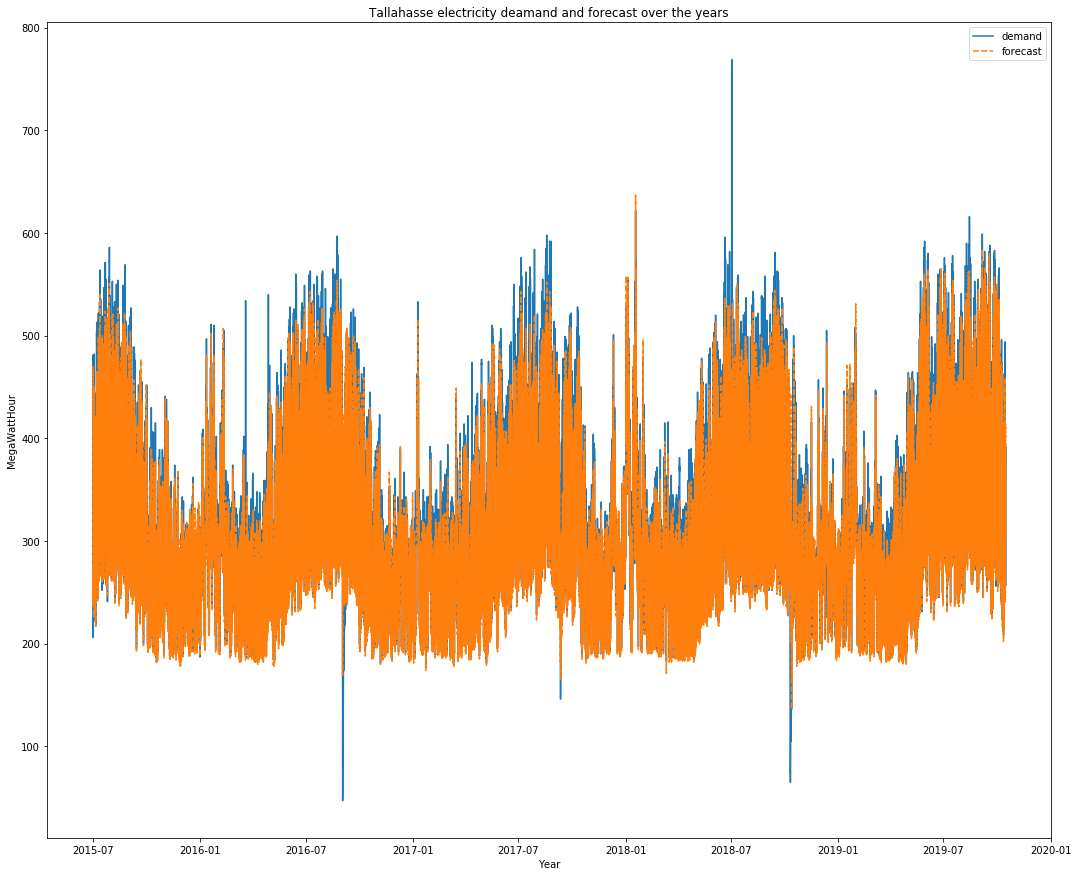

In [16]:
# Line chart 
plt.figure(figsize=(18,15))
sns.lineplot(data=tal.iloc[:,:2])
plt.xlabel('Year')
plt.ylabel('MegaWattHour')
plt.title('Tallahasse electricity deamand and forecast over the years')

### We can find some distinguishing patterns here. 
## Seasonality: Peak electricity demand during the summer time around August.  But there are some anomalies.

<a id='outliers'></a>  
### 1.3 Outliers / Anomalies. 
### From the graph above some outliers are obvious which indicate extrem low power demand in the summer time. Instead of simply deleting the outliers we try to find the reason behind. What happened on those days ? Some events, some nature Catastrophe? 

In [18]:
# show the smallest values of demand
tal.nsmallest(20, ['demand'])

,demand,forecast
2016-09-02 06:00:00,47.0,218.0
2016-09-02 05:00:00,49.0,201.0
2016-09-02 07:00:00,50.0,254.0
2016-09-02 04:00:00,51.0,196.0
2016-09-02 08:00:00,51.0,280.0
2016-09-02 09:00:00,51.0,296.0
2016-09-02 03:00:00,55.0,196.0
2016-09-02 10:00:00,55.0,317.0
2016-09-02 11:00:00,62.0,338.0
2018-10-11 05:00:00,65.0,250.0


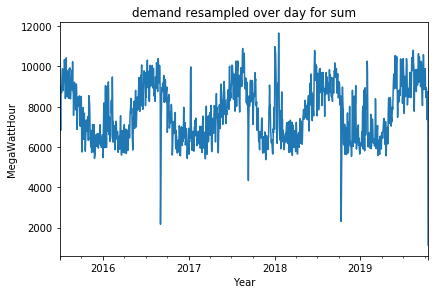

2019-10-16    1128.0
2016-09-02    2169.0
2018-10-11    2302.0
2018-10-12    3643.0
2016-09-03    4080.0
2017-09-11    4338.0
2018-10-13    4771.0
2018-10-10    5273.0
2017-11-24    5372.0
2017-03-12    5413.0
Name: demand, dtype: float64

In [19]:
# resample the data into unit day to find the special date.
tal_day = tal.demand.resample('D').sum()
tal_day.plot(title='demand resampled over day for sum') 

#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.xlabel('Year')
plt.ylabel('MegaWattHour')
plt.show()   

tal_s = tal_day.sort_values(ascending = True).head(10)
tal_s

### 2019-10-16 has only one record so that is why the sum of demand over the whole is so low. Then we recognized three time groups: 1. (2016-09-02 & 2016-09-03)   2. 2017-09-11  3. (2018.10-10 & 2018.10.11 & 2018.10.12 & 2018.10-13). 


 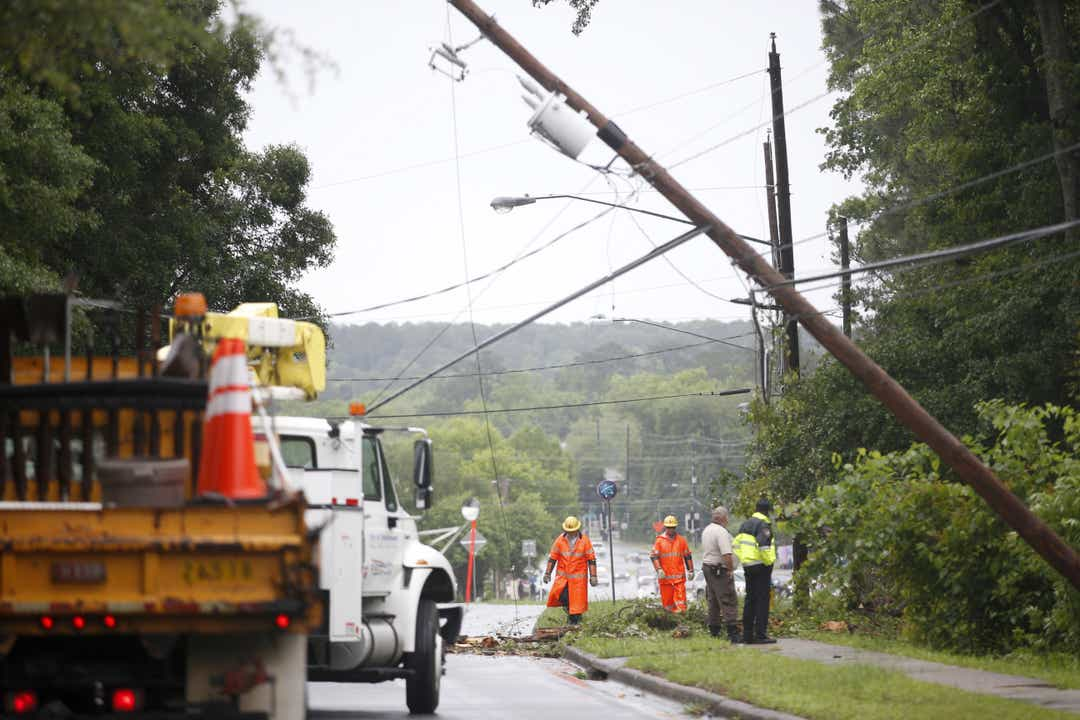
### On 2016-09-02 the power demand is extreme low at Tallahassee.  Hurricane Hermine damaged 80% of power system. So the customers did not have power on that day. <a href="https://eu.tallahassee.com/story/news/2016/09/02/70000-people-without-power-and-could-days/89759320/ " target="_blank">this link</a>


### On 2018-10-10 and  2018-10-11 again Hurricane Michael carved its path across the Florida so that hundreds thousand people has no acess to power. 
### On 2017-09-11 Hurricane Irma spares Tallahassee its worst.

### In our opinion, these anomalies did not represent the normal electricity demand. For the purpose of our project we are not able to predict futher hurricanes. We should REPLACE them with a reasonable method. For example, replace them with the same weekday of the previous week. 

In [20]:
tal_s = tal_s[1:8]

In [21]:
tal_s.index

DatetimeIndex(['2016-09-02', '2018-10-11', '2018-10-12', '2016-09-03',
               '2017-09-11', '2018-10-13', '2018-10-10'],
              dtype='datetime64[ns]', freq=None)

In [22]:
# create the index with hour frequence for those hurricane periods 
tal_id = []
for i in tal_s.index:
    idx = pd.date_range(i, periods = 24, freq = 'H')
    tal_id.append(idx)    
#tal_id

In [23]:
# concat the dataframe of hurricanes together
tal_hurricane = pd.concat([tal.loc[tal_id[i]] for i in range(7)])   

In [24]:
tal.loc[tal_hurricane.index[0]-timedelta(days=7)]

demand      353.0
forecast    352.0
Name: 2016-08-26 00:00:00, dtype: float64

In [25]:
# Replace the records during the hurricanes with the data 7 days ago. 
for i in tal_hurricane.index:
    tal_hurricane.at[i, 'demand'] =  tal.at[(i-timedelta(days=7)), 'demand']
    tal_hurricane.at[i, 'forecast'] =  tal.at[(i-timedelta(days=7)), 'forecast']
# tal.drop(tal.loc[tal_id[i]].index, inplace = True)

In [26]:
# replace the origin data with the imputed new dataset during the hurricane periods 
tal.loc[tal_hurricane.index] = tal_hurricane

In [27]:
# the dimension of the dataset after removing the anomalies.
tal.shape

(37635, 2)

Text(0.5, 1.0, 'Tallahasse electricity deamand and forecast over the years')

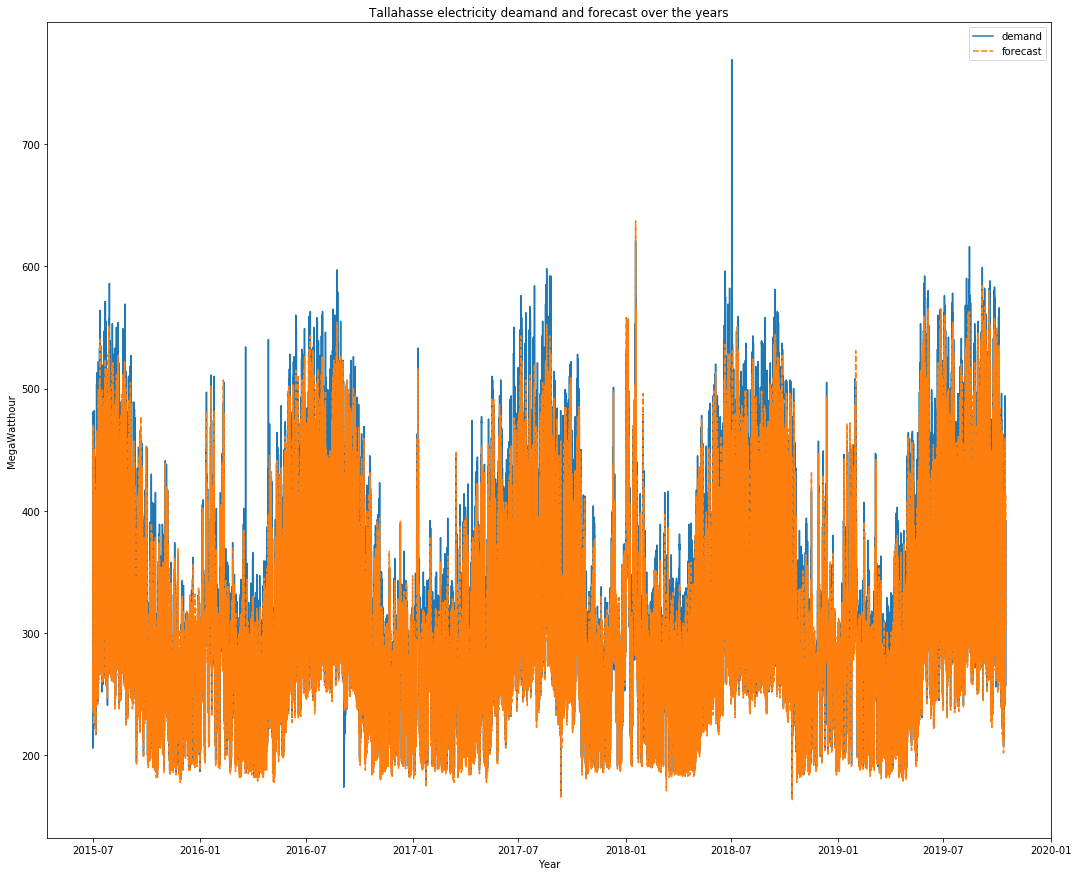

In [28]:
# Line chart. Check again the graph after removing the anomalies. 
plt.figure(figsize=(18,15))
sns.lineplot(data=tal.iloc[:,:2])
plt.xlabel('Year')
plt.ylabel('MegaWatthour')
plt.title('Tallahasse electricity deamand and forecast over the years')

## Check the highest power demand to see if there is any anomalies at that time. 

In [29]:
tal.nlargest(10, ['demand'])

,demand,forecast
2018-07-02 10:00:00,769.0,351.0
2018-01-18 08:00:00,621.0,637.0
2019-08-14 16:00:00,616.0,563.0
2019-08-14 15:00:00,606.0,561.0
2018-01-18 07:00:00,602.0,612.0
2019-08-14 17:00:00,600.0,555.0
2019-09-05 18:00:00,599.0,576.0
2017-08-18 16:00:00,598.0,552.0
2016-08-23 18:00:00,597.0,538.0
2019-09-05 17:00:00,597.0,584.0


In [30]:
tal[(tal.index>pd.to_datetime("2018-07-02 04:00:00")) & (tal.index<pd.to_datetime("2018-07-02 16:00:00"))]

,demand,forecast
2018-07-02 05:00:00,252.0,248.0
2018-07-02 06:00:00,263.0,261.0
2018-07-02 07:00:00,289.0,285.0
2018-07-02 08:00:00,309.0,305.0
2018-07-02 09:00:00,336.0,327.0
2018-07-02 10:00:00,769.0,351.0
2018-07-02 11:00:00,395.0,375.0
2018-07-02 12:00:00,419.0,397.0
2018-07-02 13:00:00,450.0,415.0
2018-07-02 14:00:00,456.0,431.0


### 2018-07-02 at 10 o'clock the demand of power is extremly high. We could not find the explanation for this. But we can not simple delete it and decided to remain it. 

In [31]:
# create a univariate dataset and save as .csv file for easy loading
tal_uni = tal.drop(columns = 'forecast')  
tal_uni.to_csv('tal_uni.csv')

In [6]:
tal_uni = pd.read_csv("tal_uni.csv", parse_dates=True, index_col = 0)

In [6]:
tal_uni.shape

(37635, 1)

In [343]:
tal_uni.iloc[-1]

demand    257.0
Name: 2019-10-16 03:00:00, dtype: float64